In this Jupyter Notebook, we will explore two types of network analysis on temporal data. Our analysis is focused on understanding the dynamics of a network over different time periods. The primary objectives of this notebook are as follows:

## Analysis 1: Time-Aware Network Centrality Measures

In the first part of our analysis, we will delve into Time-Aware Network Centrality Measures. This involves calculating various centrality metrics, such as degree centrality, betweenness centrality, and eigenvector centrality, taking into account the temporal dimension of the network. We aim to gain insights into how the centrality of nodes changes over time and understand the significance of these changes.

**Key Steps in Analysis 1:**
1. Data Preparation: Loading and preprocessing the temporal network data.
2. Centrality Metrics Calculation: Calculating time-aware centrality metrics.
3. Visualization: Visualizing the evolution of centrality metrics over time.
4. Interpretation: Drawing conclusions from the centrality metrics and their temporal variations.

## Analysis 2: Common Nodes Between Successive Time Periods

The second part of our analysis focuses on identifying common nodes between two successive time periods. This allows us to understand which nodes are consistently present in the network over time and assess their importance.

**Key Steps in Analysis 2:**
1. Data Preparation: Preparing the data for two consecutive time periods.
2. Common Node Identification: Finding nodes that exist in both time periods.
3. Similarity Metrics: Calculating similarity metrics between these common nodes.

By conducting these two types of analyses, we aim to gain a comprehensive understanding of the temporal dynamics of the network and the nodes' roles within it. This notebook will provide you with the tools and insights to explore complex network behavior over time.

Let's get started!

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from math import log

import warnings
warnings.filterwarnings('ignore')

Convert txt file to CSV

In [2]:
input_file = '../Dataset/sx-stackoverflow.txt'
output_file = '../Dataset/stackoverflow_Graphs.csv'
chunksize = 50000  # Number of rows to read and process in each iteration
delimiter = ' ' # Modify the delimiter used in our input text file (in this case it's a space)

# Define our custom header as a list
header = ['Source_Node', 'Target_Node', 'Timestamp']  

# Write the custom header to the output CSV file
with open(output_file, 'w') as file:
    file.write(','.join(header) + '\n')

# Process the text file in chunks and append to the CSV file
for chunk in pd.read_csv(input_file, delimiter=delimiter, chunksize=chunksize, header=None):
    chunk.to_csv(output_file, mode='a', index=False, header=False) # We use mode='a' (append) to avoid overwriting existing data and concatenate all the partitions of chunksize

In [29]:
output_file = '../Dataset/stackoverflow_Graphs.csv'
df = pd.read_csv(output_file)
len(df)

63497050

In [30]:
df.dtypes

Source_Node    int64
Target_Node    int64
Timestamp      int64
dtype: object

<span style='font-size: 26px;'>__Part 1__</span><br><br>
<span style='font-size: 26px;'>__Defining Sets Of Time Instances and Time Periods__</span><br><br>
<span style='font-size: 22px; color:red'>**Procedure for Temporal Network Analysis**</span>

**In this analysis, our goal is to examine a dataset of a temporal network. By dividing it into multiple time periods, we can better understand its evolution over time. Let's consider N as the number of temporal periods (intervals or segments) into which we will divide our data. Since our time interval is T = [t0=tmin, tN=tmax], the cutting points for the time periods will be N+1.**

**It is important in this analysis to ensure that there is a fixed time interval, dt, between each pair of consecutive cut points (time moments). This means that the time interval between each pair of consecutive cut points will be the same. To calculate this time interval dt, we can use the following formula:**

**dt = DT / N = (tmax - tmin) / N**

**Where DT represents the total time span of our dataset, i.e., the difference between the maximum (tmax) and minimum (tmin) time points.**

**Note that dividing the time moments of the data in this way will result in different numbers of edges (connections) in each time period. The distribution of edges follows an increasing approach, meaning that as time progresses within each time period, we will have more edges (interactions) compared to the previous one. Therefore, we must carefully choose the number of temporal intervals N to ensure that each time period dt contains a sufficient number of interactions among users (edges) to effectively capture the evolution of these interactions over time.**

**Based on the above, we can determine the relationship that connects each of the N+1 cut points with the respective time moment using the formula:**

**tj = tmin + j * dt → tj = tmin + (tmax – tmin) / N * j,   0 <= j <= N**

**Essentially, by using this simple mathematical relationship, we can find the specific time moment (tj) for each value of j from 0 to N. This helps us understand how the time span varies in different time periods.**

<span style='font-size: 22px; color:red;'>****Define the N parameter****</span><br>
**Source: https://snap.stanford.edu/data/sx-stackoverflow.html**<br><br>
**Dataset Statistics:**<br>
Nodes: 2.601.977<br>
Temporal Edges: 63.497.050<br>
Edges in the static graph: 36.233.450<br>
Time span: 2.774 days

**Research Goals:**<br>
Our research goals involve analyzing the temporal evolution of the network, studying various centrality measures, and understanding the persistent nodes between time periods.

**So if we considering this research goals and the large number of nodes and the relatively long time span, a value of N that represents monthly intervals seems reasonable. This choice will provide a good balance between granularity and statistical significance.**

In [31]:
# We see if the Timestamps is in ascending shorted 
df.Timestamp.is_monotonic_increasing

False

In [32]:
# We short the Timestamps
df.sort_values(by='Timestamp', inplace=True)
df.Timestamp.is_monotonic_increasing

True

In [6]:
df.head(20)

,Source_Node,Target_Node,Timestamp
0,9,8,1217567877
1,1,1,1217573801
2,13,1,1217606247
3,17,1,1217617639
4,48,2,1217618182
5,17,1,1217618239
6,19,9,1217618357
7,13,23,1217618560
8,13,11,1217618799
9,23,23,1217619360


In [35]:
# Calculate the Complete Time Period
print(f'The complete time period is T = [ {df.Timestamp.min()}, {df.Timestamp.max()} ]\n')

# Define the N parameter for monthly intervals
N = int(2774 / 30 )
# Calculate the set of time instances
# -----------------------------------
# Step 1: Calculate the time interval length
DT =  df.Timestamp.max() - df.Timestamp.min()
# Step 2: Calculate the length of each non-overlapping time period
dt = DT / N
print(f'The length of each non-overlapping Time Period is dt = {dt} secs.')
# Step 3 : Determine the set of time instances {t0, ..., tN}
time_instances = [df.Timestamp.min() + ( j * dt) for j in range(N+1)]

# Calculate the set of non-overlapping time periods 
# -------------------------------------------------
# The time_instances list will contain N+1 time instances which represent the start times of each non-overlapping time period {T1, ..., TN}
# The end times of each time period will be the following time instance in the time_instances list
# Determine the set of non-overlapping time periods {T1, ..., TN}
time_periods = [(time_instances[i], time_instances[i + 1]) for i in range(N)]

# Print the non-overlapping time periods
print('Time Periods:')
for i, (start_time, end_time) in enumerate(time_periods):
    print(f'T{i+1}: [{start_time}, {end_time}]')

# Print the set of time instances
print('\nTime Instances:')
for i in range(len(time_instances)):
    print(f't{i}: {time_instances[i]}')

The complete time period is T = [ 1217567877, 1457273428 ]

The length of each non-overlapping Time Period is dt = 2605495.1195652173 secs.
Time Periods:
T1: [1217567877.0, 1220173372.1195652]
T2: [1220173372.1195652, 1222778867.2391305]
T3: [1222778867.2391305, 1225384362.3586957]
T4: [1225384362.3586957, 1227989857.4782608]
T5: [1227989857.4782608, 1230595352.597826]
T6: [1230595352.597826, 1233200847.7173913]
T7: [1233200847.7173913, 1235806342.8369565]
T8: [1235806342.8369565, 1238411837.9565217]
T9: [1238411837.9565217, 1241017333.076087]
T10: [1241017333.076087, 1243622828.1956522]
T11: [1243622828.1956522, 1246228323.3152175]
T12: [1246228323.3152175, 1248833818.4347825]
T13: [1248833818.4347825, 1251439313.5543478]
T14: [1251439313.5543478, 1254044808.673913]
T15: [1254044808.673913, 1256650303.7934783]
T16: [1256650303.7934783, 1259255798.9130435]
T17: [1259255798.9130435, 1261861294.0326087]
T18: [1261861294.0326087, 1264466789.152174]
T19: [1264466789.152174, 1267072284.2717

**We Generate Subgraphs For Each Time Period to Simplify Calculations and to Analyze The Graph to Partitions**

    **First Implometation Without Generator but is to slow**

In [ ]:
# Initialize an empty list to store the subgraphs for each time period
subgraphs = []

# Loop through the time periods and create subgraphs
for j, (start_time, end_time) in enumerate(time_periods):
    # The following condition avoid duplicates by handling the same Timestamps in separate time periods to prevent redundant information from being written twice.
    if j < N:
        filtered_df = df[ (df.Timestamp >= start_time) & (df.Timestamp < end_time) ] # if 1 <= j <= N-1 then Tj = [tj-1, tj)
    else:
        filtered_df = df[ (df.Timestamp >= start_time) & (df.Timestamp <= end_time) ] # if j = N then Tj = [tj-1, tj]
    subgraph = nx.Graph()
    subgraph = nx.from_pandas_edgelist(filtered_df, 'Source_Node', 'Target_Node', 'Timestamp')
    subgraphs.append(subgraph)

    **Second Implomentation With Generator It's Runs Significantly Faster**

In [33]:
# Initially, we develop a function that generates a graph based on a specific dataframe
def create_subgraph(subdf):
    subgraph = nx.from_pandas_edgelist(subdf, 'Source_Node', 'Target_Node')
    return subgraph

#We employ a generator to create subgraphs instead of storing everything in memory
# This approach allows us to efficiently utilize specific graphs for particular tasks
def subgraphs_generator(df, time_periods):
    for start, end in time_periods[:-1]:
        # Subdividing the dataframe for the current time period
        subdf = df[(df.Timestamp >= start) & (df.Timestamp < end)]
        subdf_copy = subdf.copy()
        subdf_copy[['Source_Node', 'Target_Node']] = np.sort(subdf_copy[['Source_Node', 'Target_Node']], axis=1)
        subdf = subdf_copy
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        yield subgraph

    # Handle the final time period separately
    start, end = time_periods[-1]
    subdf = df[(df.Timestamp >= start) & (df.Timestamp <= end)]
    subdf_copy = subdf.copy()
    subdf_copy[['Source_Node', 'Target_Node']] = np.sort(subdf_copy[['Source_Node', 'Target_Node']], axis=1)
    subdf = subdf_copy
    subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
    subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
    subgraph = create_subgraph(subdf)
    yield subgraph

In [34]:
# Develop a function to calls the subgraph corresponding to the i-th index
def ith_subgraph(df, time_periods, index):
    if index < len(time_periods) - 1:
        start, end = time_periods[index]
        subdf = df[(df.Timestamp >= start) & (df.Timestamp < end)]
        subdf_copy = subdf.copy()
        subdf_copy[['Source_Node', 'Target_Node']] = np.sort(subdf_copy[['Source_Node', 'Target_Node']], axis=1)
        subdf = subdf_copy
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        return subgraph
    else:
        start, end = time_periods[-1]
        subdf = df[(df.Timestamp >= start) & (df.Timestamp <= end)]
        subdf.loc[:, ['Source_Node', 'Target_Node']] = np.sort(subdf[['Source_Node', 'Target_Node']], axis=1)
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        return subgraph

**Plot First 2 Subgraphs for our Network**

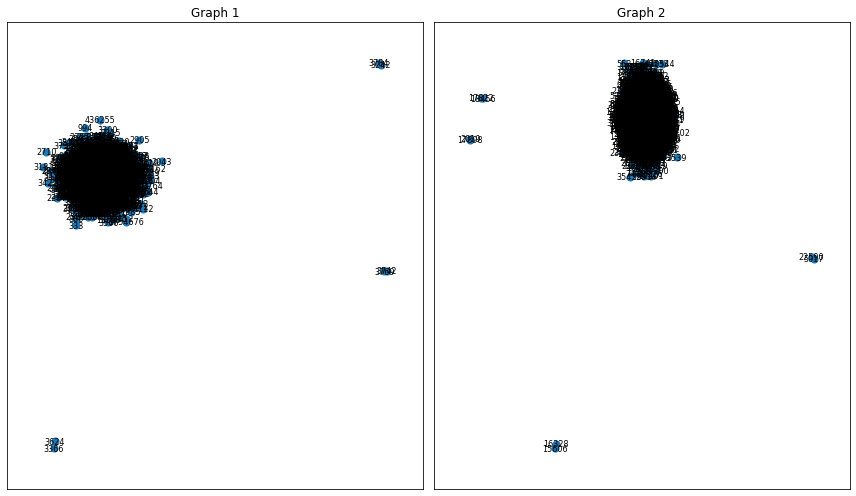

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i in range(2):
    G = ith_subgraph(df, time_periods, i)
    pos = nx.spring_layout(G)

    ax = axes[i]
    ax.set_title(f"Graph {i + 1}")

    nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

plt.tight_layout()
plt.show()

Let's see the Nodes and Connections in the First 5 Subgraphs and the Last 5 Subgraphs

In [10]:
print('The first 5 Graphs: ')
for i in range(5):
    print(ith_subgraph(df,time_periods,i))
print('The last 5 Graphs: ')
for i in range(-5,0):
    print(ith_subgraph(df,time_periods,i))


The first 5 Graphs: 


Graph with 2124 nodes and 13124 edges
Graph with 9355 nodes and 62257 edges
Graph with 9660 nodes and 61843 edges
Graph with 9684 nodes and 48148 edges
Graph with 9358 nodes and 43669 edges
The last 5 Graphs: 
Graph with 240374 nodes and 505882 edges
Graph with 234128 nodes and 484924 edges
Graph with 217087 nodes and 448032 edges
Graph with 252197 nodes and 530161 edges
Graph with 262962 nodes and 560860 edges


It's evident that on the initial day of this dataset, Stack Overflow had just 2124 users with 13124 connections. As time progressed in the last day, it grew to encompass 262962 users and 560860 connections. Now, let's explore the temporal evolution.

<span style='font-size:24px'>**Time Evolution** between successive time periods : **Tj -> Tj+1**</span><br><br>
**When we want to demonstrate the way in which the network G evolves between successive time periods, that is how the connections and nodes change, we refer to the transformation G[tj-1, tj] -> G[tj, tj+1].**<br><br>
 **So, the desired elements we need to calculate is are:**
   - **The variation related to how the set of nodes evolves from one time period to the next, that is the transformation    V[tj-1, tj] -> V[tj, tj+1].**<br>
   - **As well as the variation related to how the set of interconnections between nodes changes from one time period to the next, that is, the transformation    E[tj-1, tj] -> E[tj, tj+1].**

In [11]:
# Initialize a emptis list to keep node and edges counts of every subgraph
node_counts = []
edge_counts = []

# Count the Nodes and the Edges for each Time Period
for graph in subgraphs_generator(df,time_periods):
    node_counts.append(graph.number_of_nodes())
    edge_counts.append(graph.number_of_edges())

# Keep the time instances when the Time Period ends for each subgraph
end_time_instances = [time_instances[i] for i in range(1, N+1)]
print(node_counts)
print(edge_counts)

[2124, 9355, 9660, 9684, 9358, 11131, 13202, 13471, 14523, 17751, 19040, 20532, 22344, 22080, 26828, 33348, 32639, 33894, 38227, 40142, 40008, 43702, 45633, 47461, 51224, 50555, 51943, 57320, 61755, 62407, 74050, 81696, 84207, 82745, 86133, 89885, 91190, 93782, 94258, 97298, 101908, 100956, 116345, 120913, 125546, 127612, 124346, 134220, 137582, 135336, 145951, 153063, 154752, 140147, 169981, 177575, 178994, 179053, 178103, 173660, 186172, 184737, 190033, 199278, 206357, 181179, 212924, 227437, 221405, 206526, 204487, 201438, 200462, 202307, 209391, 208834, 217971, 190466, 218972, 228326, 236178, 240681, 230628, 236348, 236975, 227383, 233432, 240374, 234128, 217087, 252197, 262962]
[13124, 62257, 61843, 48148, 43669, 60620, 75198, 69525, 73243, 89410, 95808, 102163, 105826, 101332, 114527, 141941, 132694, 139227, 157611, 158432, 144703, 158039, 164500, 173582, 186879, 181216, 182267, 201194, 216479, 209126, 253139, 283195, 288383, 275128, 289970, 294629, 292666, 294593, 290223, 297857

In [12]:
# Convert the end_time_instances seconds to days 
secs_in_days = 24*60*60
end_time_instances_inDays = [seconds / secs_in_days for seconds in end_time_instances]
print(end_time_instances[0],'secs')
print(end_time_instances_inDays[0], 'days')

1220173372.1195652 secs
14122.376992124598 days


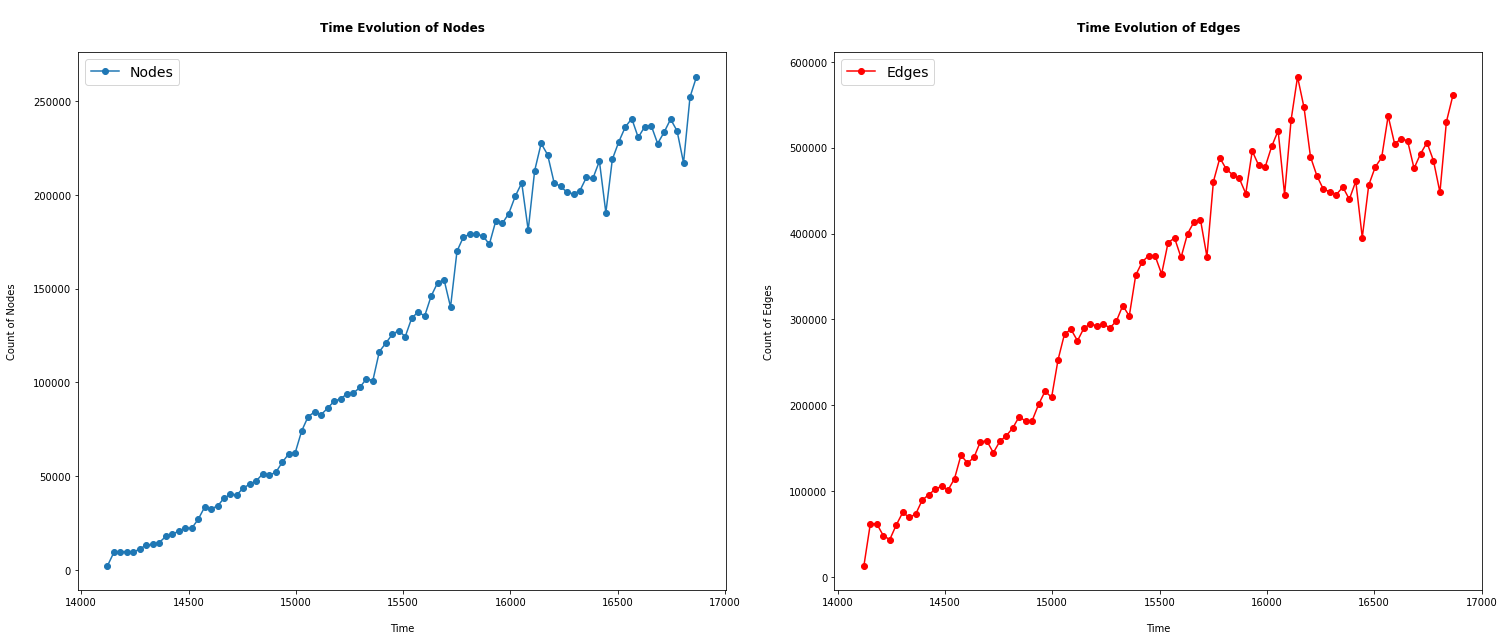

In [13]:
# Create a plot of the time evolution of node and edge counts
plt.figure(figsize=(21, 9))

# First subplot for Nodes
plt.subplot(1, 2, 1)
plt.plot(end_time_instances_inDays, node_counts, marker='o', label='Nodes',) # 
plt.xlabel('\nTime')
plt.ylabel('Count of Nodes\n')
plt.title('\nTime Evolution of Nodes\n', fontweight='bold')
plt.legend(loc='upper left', fontsize=14)

# Second subplot for Edges
plt.subplot(1, 2, 2)
plt.plot(end_time_instances_inDays, edge_counts, marker='o', label='Edges', color='red')
plt.xlabel('\nTime')
plt.ylabel('\nCount of Edges\n')
plt.title('\nTime Evolution of Edges\n', fontweight='bold')
plt.legend(loc='upper left', fontsize=14)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

As time goes by, more users join the website and more connections are made. We notice occasional decreases in nodes and edges but, in general, there is an overall upward trend.

# Centrality Measures

**a) Degree Centrality**: It's one of the simplest measures of centrality based on the number of connections a node has. Nodes with a high degree centrality are considered more central because they have many direct connections to other nodes.
- **Nodes with higher degree centrality play a more important role in the network and can quickly spread information or influence others.**
- **Degree centrality is useful for identifying important nodes in unweighted networks where the strength of connections is not so important.**
  
**b) Closeness Centrality**: It measures how close a node is to all other nodes in the network, meaning how easily a node can reach other nodes. Nodes with high closeness centrality have shorter average paths to other nodes, making them easily accessible from the rest of the network.
- **Nodes with high closeness centrality are more central in terms of their ability to efficiently communicate or spread information to all other nodes in the network.**
- **Closeness centrality is crucial in situations where fast and effective communication is critical.**
  
**c) Betweenness Centrality**: It measures the number of shortest paths that pass through a node, showing how important a node is in terms of connecting other nodes.
- **Nodes with high betweenness centrality act as critical bridges between groups of nodes.**
- **Nodes with high betweenness centrality are important for maintaining network cohesion and can significantly impact communication and information flow.**
  
**d) Eigenvector Centrality**: This measure considers both the centrality of a node and the centrality of its neighbors. It shows how well connected a node is to other important nodes in the network. Nodes with high eigenvector centrality are well-connected to other central nodes.
- **Nodes with high eigenvector centrality are not only directly connected to important nodes but also indirectly connected to other important nodes in the network.**
- **Eigenvector centrality can reveal nodes that have significant influence on the overall structure and influence of the network.**
  
**e) Katz Centrality**: This measure is an extension of eigenvector centrality that considers not only immediate neighbors but also nodes that can be reached through longer paths, giving more importance to nodes that can influence others through multiple connections.
- **Katz centrality helps identify nodes that have influence over a wide range of other nodes, even if they are not directly connected.**
- **It captures the influence of nodes beyond immediate neighbors, making it suitable for situations where indirect influence is important.**

In [37]:
# Function that provides centrality measures for a given graph
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    katz_centrality = nx.katz_centrality(G, alpha=0.01, beta=0.1, max_iter=5000)

    return degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality, katz_centrality

In [15]:
# Calculating Centrality Measures for the First Subgraph
centrality_tuple = compute_centrality_measures(ith_subgraph(df, time_periods, 0))
columns = ['node', 'degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'katz_centrality']

data = []
for node, degree_centrality in centrality_tuple[0].items():
    row = [node, degree_centrality]
    row.extend(centrality_tuple[i][node] for i in range(1, len(centrality_tuple)))
    data.append(row)

centralities = pd.DataFrame(data, columns=columns)
centralities.head(15)

,node,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,katz_centrality
0,8,0.002355,0.312558,0.000023,0.005717,0.019054
1,9,0.011305,0.353308,0.002590,0.021489,0.024184
2,1,0.039567,0.405030,0.014949,0.083606,0.041440
3,13,0.016015,0.367709,0.002942,0.032373,0.027207
4,17,0.037683,0.403636,0.012668,0.080279,0.040271
5,2,0.005181,0.322835,0.001162,0.010233,0.020558
6,48,0.007065,0.357618,0.000624,0.026968,0.023168
7,19,0.000471,0.260909,0.000000,0.000549,0.017790
8,23,0.001884,0.272003,0.000185,0.000920,0.018378
9,11,0.000942,0.276601,0.000004,0.001282,0.018050


In [16]:
# We don't have duplicates nodes
max(centralities.node.value_counts())

1

But if we were to apply these calculations to the entire network, it could become chaotic. Instead, we'll implement these calculations on just one or two subgraphs.<br> Let's try it in the first Graph:

In [38]:
degree_centrality1, closeness_centrality1, betweenness_centrality1, eigenvector_centrality1, katz_centrality1 = compute_centrality_measures(ith_subgraph(df,time_periods,0))

Visualize the Log-Scaled Probabilities of a node's degree centrality for the first subgraph

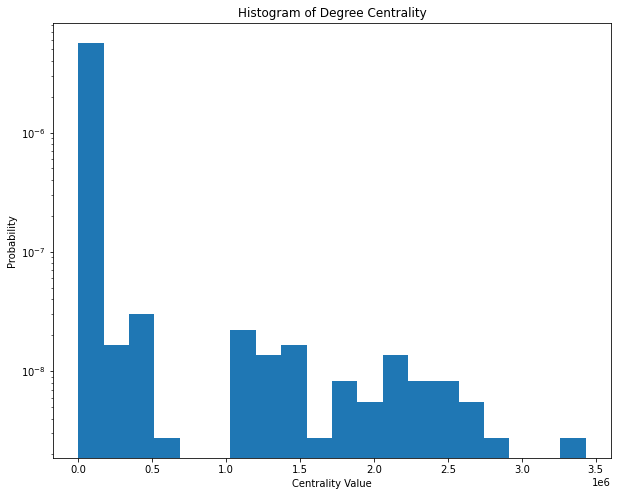

In [39]:
plt.figure(figsize=(10,8))
plt.hist(degree_centrality1, bins=20, density=True)
plt.title('Histogram of Degree Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Probability')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

It appears that there is a substantial number of nodes with low degree centrality values. We will proceed by creating **Kernel Density Estimation** (KDE) plots to visualize the smoothed distributions of all centrality measures

In [25]:
def plot_centralities(df,time_periods,i):
    degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality, katz_centrality = compute_centrality_measures(ith_subgraph(df, time_periods, i))
    centrality_names = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality', 'Katz Centrality']
    plt.figure(figsize=(9, 6))

    for centrality, name in zip([degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality, katz_centrality], centrality_names):
        sns.kdeplot(centrality, label=name)

    plt.title(f'Kernel Density Estimation of Centralities for Graph {i + 1}')
    plt.xlabel('Centrality Value')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

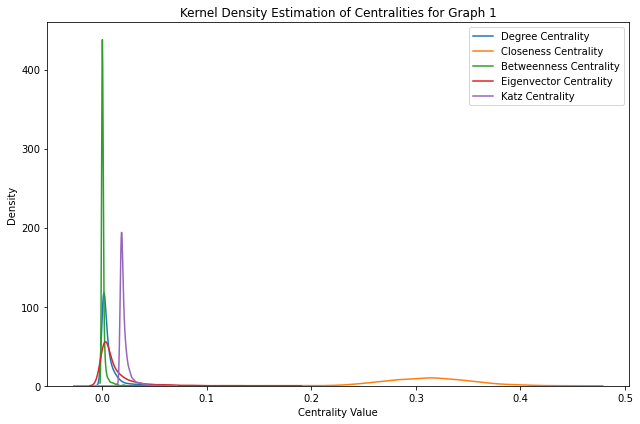

In [26]:
plot_centralities(df,time_periods,0) #Plot the 1st subgraph of the dataset

Now we are calculating the centralities for the 6 and 7 subgraphs and we plot it

In [40]:
# Calculating the centralities for the 6 and 7 subgraphs
degree_centrality1, closeness_centrality1, betweenness_centrality1, eigenvector_centrality1, katz_centrality1 = compute_centrality_measures(ith_subgraph(df,time_periods,5))
degree_centrality2, closeness_centrality2, betweenness_centrality2, eigenvector_centrality2, katz_centrality2 = compute_centrality_measures(ith_subgraph(df,time_periods,6))

centrality_measures1 = [ degree_centrality1, closeness_centrality1, betweenness_centrality1, eigenvector_centrality1, katz_centrality1]
centrality_measures2 = [ degree_centrality2, closeness_centrality2, betweenness_centrality2, eigenvector_centrality2, katz_centrality2]
                       
# We are create this titles for our plots 
titles = ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "Eigenvector Centrality", "Katz Centrality"]

#### Visualizing Probability Distributions of Centrality Measures

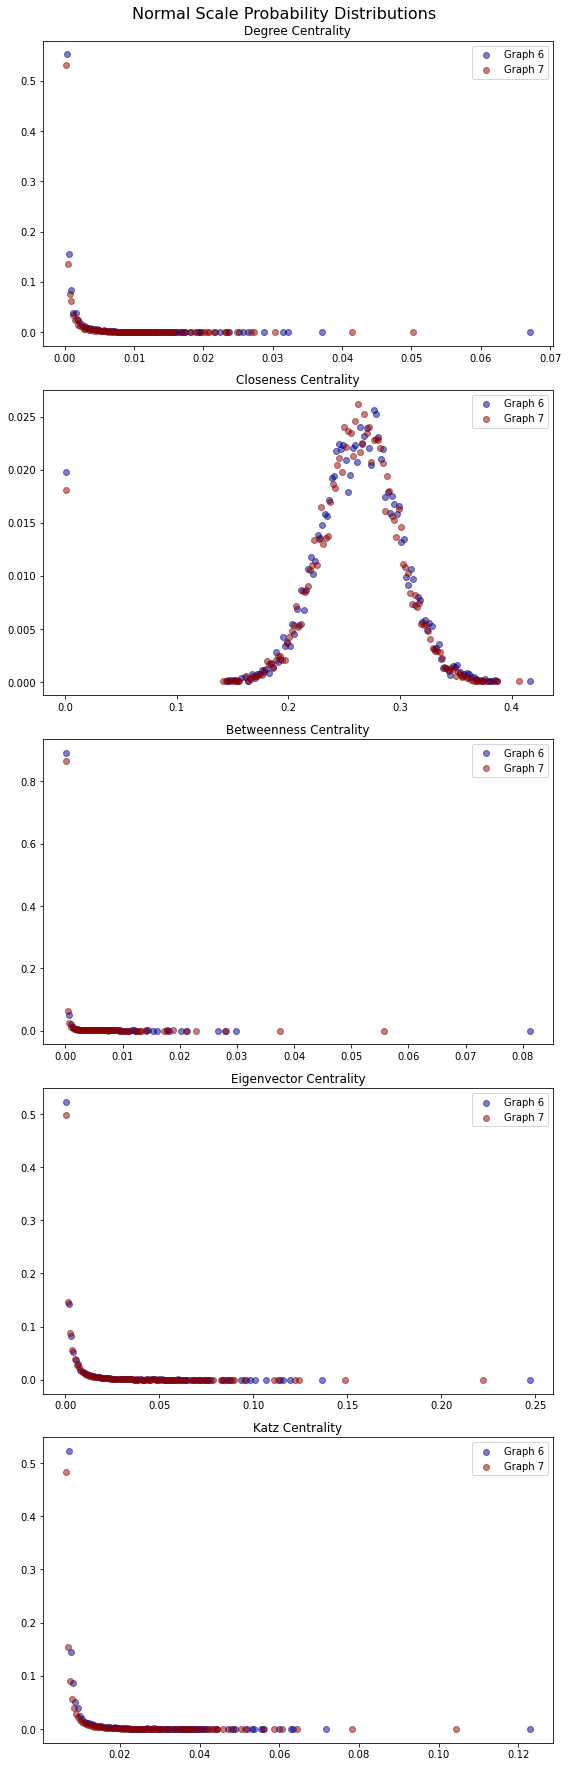

In [45]:
# Create a figure with 5 subplots arranged in a single column, specifying the figure size
fig, axes = plt.subplots(5, 1, figsize=(8, 25))

# Iterate through the centrality measures, their titles, and a row index
for row, (measure1, measure2,title) in enumerate(zip(centrality_measures1, centrality_measures2,titles)):
    # Extract values from the first centrality measure
    values1 = list(measure1.values())
    # Compute a histogram and associated bin information for the values
    hist1, bins1 = np.histogram(values1, bins=200)
    # Calculate the center of each bin
    bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
    # Filter out bins and histogram data where the frequency is greater than 0
    bin_centers1 = bin_centers1[hist1 > 0]
    hist1 = hist1[hist1 > 0]
    # Normalize the histogram data by dividing by the total number of values
    hist1 = (hist1 / len(values1))

    values2 = list(measure2.values())
    hist2, bins2 = np.histogram(values2, bins=200)
    bin_centers2 = (bins2[:-1] + bins2[1:]) / 2
    bin_centers2 = bin_centers2[hist2 > 0]
    hist2 = hist2[hist2 > 0]
    hist2 = (hist2 / len(values2))

    # Create a scatter plot of the first centrality measure's histogram
    axes[row].scatter(bin_centers1, hist1, marker='o', color='darkblue', alpha=0.5, label = 'Graph 6')
    # Create a scatter plot of the second centrality measure's histogram
    axes[row].scatter(bin_centers2, hist2, marker='o', color='darkred', alpha=0.5, label = 'Graph 7')
    axes[row].set_title(title)      
    axes[row].legend(loc='upper right')
    
plt.suptitle("Normal Scale Probability Distributions\n", fontsize=16)  
plt.tight_layout()

**The distribution of centralities** in our network exhibits an intriguing pattern. With the exception of *closeness centrality*, which appears to conform to a **normal distribution**, the other centralities seem to adhere to a **Power-Law distribution**. In this context, Power-Law distribution implies that a large proportion of nodes have relatively low centrality scores, while only a small subset of nodes manage to attain high centrality values.

In other words, the network's structure is such that most nodes play relatively minor roles, while only a select few hold significant sway within the network. This insight underscores the presence of a hierarchical or scale-free structure in the network, where a few nodes serve as crucial hubs or connectors, exerting a disproportionate influence on the overall network dynamics.

To gain further clarity on the centrality distributions, we should examine them on a *log-log scale*. This approach can provide additional insights into the network's underlying structure and help us confirm the nature of these distributions.


#### Visualizing Probability Distributions of Centrality Measures in Log-Log Scale

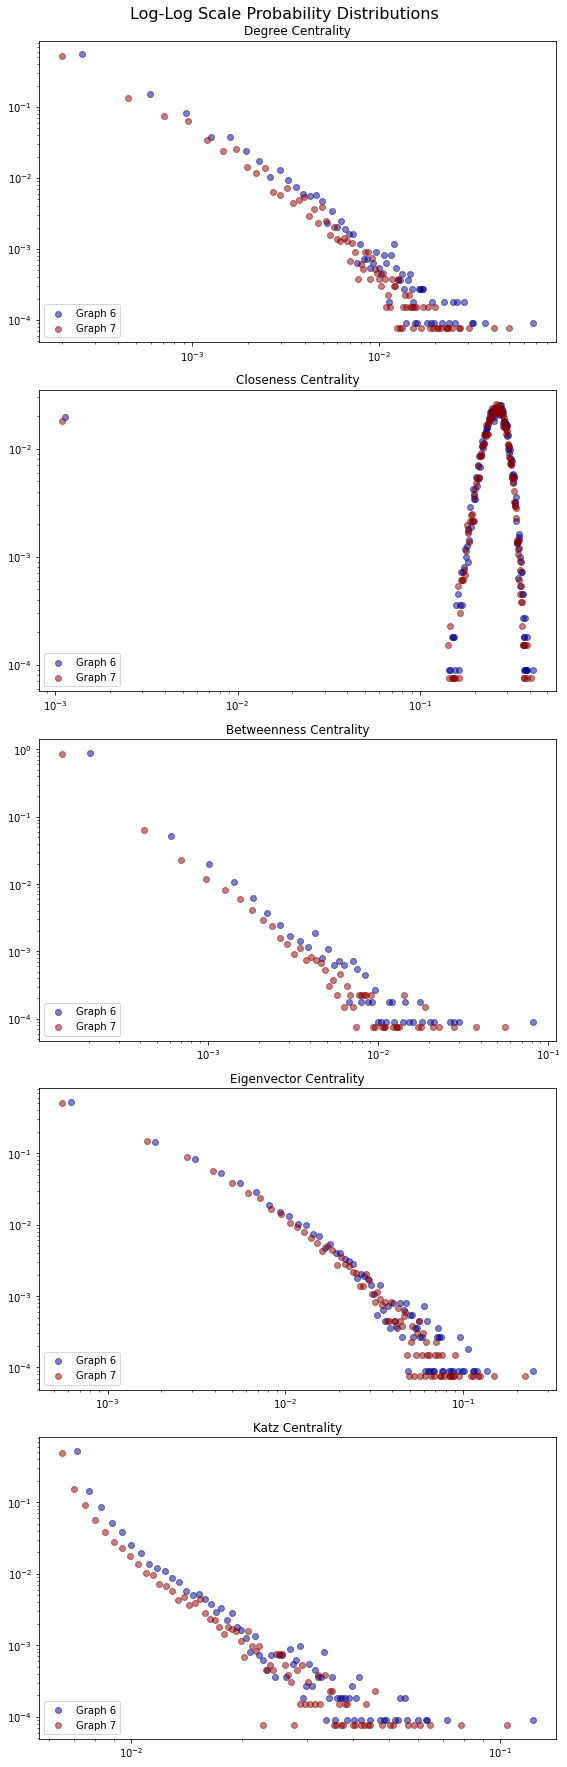

In [46]:
fig, axes = plt.subplots(5, 1, figsize=(8, 25))

# Iterating Through Centrality Measures
for row, (measure1, measure2,title) in enumerate(zip(centrality_measures1, centrality_measures2,titles)):
    # Processing centrality measure 1
    values1 = list(measure1.values())
    hist1, bins1 = np.histogram(values1, bins=200)
    bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
    bin_centers1 = bin_centers1[hist1 > 0]
    hist1 = hist1[hist1 > 0]
    hist1 = (hist1 / len(values1))

    # Processing centrality measure 2
    values2 = list(measure2.values())
    hist2, bins2 = np.histogram(values2, bins=200)
    bin_centers2 = (bins2[:-1] + bins2[1:]) / 2
    bin_centers2 = bin_centers2[hist2 > 0]
    hist2 = hist2[hist2 > 0]
    hist2 = (hist2 / len(values2))

    # Creating Scatter Plots
    axes[row].scatter(bin_centers1, hist1, marker='o', color='darkblue', alpha=0.5, label = 'Graph 6')
    axes[row].scatter(bin_centers2, hist2, marker='o', color='darkred', alpha=0.5, label = 'Graph 7')
    axes[row].set_title(title)      
    # Adding Legends and Scaling
    axes[row].legend(loc='lower left')
    axes[row].set_yscale('log')
    axes[row].set_xscale('log')
    
plt.suptitle("Log-Log Scale Probability Distributions\n", fontsize=16)  
plt.tight_layout()

In the log-log scale, we observe that the centrality distributions exhibit a **nearly linear pattern with subtle curves**, characterized by **heteroscedasticity**. This behavior suggests that these distributions adhere to a **Truncated Power-Law Distribution**, where the tail of the distribution is bounded by the **maximum centrality measure found in the data**. This truncated power law distribution emergence can be attributed to the effects of either **aging or cost**.

In this network, it appears that newer nodes tend to prefer attaching themselves to well-established and highly connected nodes, often referred to as "**hubs**." This preferential attachment phenomenon contributes to the observed distribution characteristics.

However, merely observing plots might not provide a precise understanding of how these distributions evolve over time. To gain deeper insights into the changes of these distributions, we employ the **Kullback-Leibler (KL) divergence measure**. KL divergence allows us to **quantitatively assess** the extent to which each distribution changes over time. It serves as a valuable tool for analyzing the dynamics of these centrality distributions and shedding light on the evolving network structure.<br><br>

<div align="center">

#### **The Mathematical Formula of the KL Divergence is:**
$$
\mathbf{D_{KL}(P\|Q) = \sum_{x} P(x) \log\frac{P(x)}{Q(x)}}
$$


**• P(x)**: Probability of event x in distribution P.<br>
**• Q(x)**: Probability of event x in distribution Q.<br>
</div>

In [47]:
from scipy.special import kl_div

In [48]:
# Create a function that creates probability distributions
def create_probability_distribution(values):
    total = sum(values)
    probabilities = [v / total for v in values]
    return probabilities

# Create a normalization function of the probabilities. We will add a tiny number to every probability to ensure we have all the p(x) and q(x) both > 0 and avoid dividing by 0.
def normalize_probabilities(probabilities, epsilon=1e-10):
    total = sum(probabilities) + len(probabilities) * epsilon
    normalized_probabilities = [(p + epsilon) / total for p in probabilities]
    return normalized_probabilities

Now compute the KLs for all the 5 centralities by using the following function (get_kl_div):

**It's important to note that distributions can vary in length, which poses a challenge for using KL-Divergence. To address this, we consistently truncate the distribution with the greater number of nodes (post-truncation).**

In [49]:
def get_kl_div(measures1,measures2):
        dist1 = create_probability_distribution(list(measures1.values()))
        dist2 = create_probability_distribution(list(measures2.values()))      
        min_length = min(len(dist1), len(dist2))
        dist1 = dist1[:min_length]
        dist2 = dist2[:min_length]
        dist1_norm = normalize_probabilities(dist1)
        dist2_norm = normalize_probabilities(dist2)
        return np.sum(kl_div(dist1_norm,dist2_norm))

We summed the KL-Divergence values because KL-Divergence calculates the difference between each x-valued centrality measure, and we sought a comprehensive value that encapsulates the overall distinction between the two distributions. So we calcluate every KL-Div for the first 5 different Graphs, for every different centrality measurement.

In [50]:
kl_degree = get_kl_div(degree_centrality1,degree_centrality2)
kl_close = get_kl_div(closeness_centrality1,closeness_centrality2)
kl_bet = get_kl_div(betweenness_centrality1,betweenness_centrality2)
kl_eigen = get_kl_div(eigenvector_centrality1,eigenvector_centrality2)
kl_katz = get_kl_div(katz_centrality1,katz_centrality2)

And now let's check how each centrality measure differenciates between the 6th and the 7th month of the dataset.

In [51]:
print('The KL - Divergence for the Graphs 6 & 7 are: ')
print('-----------------------------------------------------')
print(f'Degree Centrality: {kl_degree}')
print(f'Closeness Centrality: {kl_close}')
print(f'Betweeness Centrality: {kl_bet}')
print(f'Eigenvector Centrality: {kl_eigen}')
print(f'Katz Centrality: {kl_katz}')

The KL - Divergence for the Graphs 6 & 7 are: 
-----------------------------------------------------
Degree Centrality: 1.388363520359464
Closeness Centrality: 0.14697931031144357
Betweeness Centrality: 4.4435713934248895
Eigenvector Centrality: 2.031828358865813
Katz Centrality: 0.09930175850173283


**We observe that indeed the most significant distribution shrinkage occurs due to betweenness centrality**, while significant contractions toward lower values are also observed in **degree and eigenvector centrality**. This result leads us to the following conclusions about our network:

1. Since **degree centrality** contracts to lower centrality values over time, we understand that new nodes entering the network prefer to connect with the more famous nodes. This results in the phenomenon that "the rich get richer, and the poor stay poor."

2. This significant change in **betweenness centrality** shows that fewer nodes act as important "bridges" connecting the entire network.

3. The change in **eigenvector centrality** indicates that over time, most users tend to have "less popular friends," influenced by the phenomenon that new nodes prefer to connect with more popular nodes.

Having drawn the above conclusions from the centrality measure distributions, we can confidently assume that we are dealing with a **scale-free network**, where:

1. Nodes increase over time.
2. New nodes entering the network prefer to connect with more famous nodes.

More specifically, our network is a **truncated scale-free network**, as indicated by the curve in the log-log scale distribution of degree centrality. This curve can be attributed to:

1. **Age Effect**: Older nodes stop making connections over time.
2. **Cost Effect**: Maintaining connections has associated costs, making it impossible for a node to have an infinite number of connections.<br><br>

<span style='font-size: 24px'>__We are conducting a more meaningful analysis.__</span><br><br>
**In the above situation, we divided our initial graph into N subgraphs, each representing a different time period. This means we have N different graphs, and if there is a connection between two nodes during time period T1, that connection will no longer be present in our graph during time period T2. To overcome this, we need an analysis that includes consecutive snapshots.**<br><br>
__So, in these two consecutive snapshots, there should be some information that remains constant, meaning there should be something common that connects these two graphs. This is a common set of nodes between consecutive time periods. We can call it the set of common nodes V *.__<br><br>
__To calculate this set, we use the formula:__<br>
__V* [tj−1, tj+1] = V [tj−1, tj ] ∩ V [tj , tj+1],   where 1 ≤ j ≤ N.__<br><br>
**Note:** We need to ensure that the intersection set has a sufficient size for all the sets between time periods, i.e. no intersection set can be an empty set. To achieve this, we should be careful about the parameter N. It shouldn't be too large to create empty sets, and it shouldn't be too small to ensure a faster analysis.<br><br>
**Apart from the set of common nodes, we also need the set of their edges. To obtain each required set , we must impose some constraints on the connections between nodes. These constraints are characterized by the following sets:**<br>
- **a)** E* [tj−1, tj ] = {(u, v) ∈ E[tj−1, tj ] : u ∈ V* [tj−1, tj+1] ∧ v ∈ V* [tj−1, tj+1]}
- **b)** E* [tj , tj+1] = {(u, v) ∈ E[tj , tj+1] : u ∈ V* [tj−1, tj+1] ∧ v ∈ V* [tj−1, tj+1]}
  
**With these constraints, we ensure that we don't include connections that correspond to common nodes between consecutive time periods and nodes from the previous and the next time period. Essentially, we want to keep only the edges that are entirely within the intersection of our common vertices.**

In [17]:
# Function to find the common set of nodes between two subgraphs
def common_nodes(subgraph_current, subgraph_next):
    return set(subgraph_current.nodes()).intersection(subgraph_next.nodes())

# Function to find the restricted set of edges within the common set of nodes
def restricted_edges(subgraph, common_nodes):
    return [(u, v) for u, v in subgraph.edges() if (u in common_nodes and v in common_nodes)]

# Lists to store the sets for each pair of successive time periods
V_STAR = []
E_STAR_PREV = []
E_STAR_NEXT = []

# Initialize the first subgraph as the previous / current
graph_previous = ith_subgraph(df,time_periods,0)

# Loop through each pair of successive time periods (Tj, Tj+1) where 1 ≤ j ≤ N - 1, 
# starting from the second time period because the first one is already initialized.
for graph_next in subgraphs_generator(df, time_periods[1:]):

    # Calculate the common set of nodes V∗[tj−1, tj+1]
    v_star = common_nodes(graph_previous,graph_next)
    V_STAR.append(len(v_star))

    # Calculate the restricted sets of edges E∗[tj−1, tj] and E∗[tj, tj+1]
    e_star_prev = restricted_edges(graph_previous, v_star)
    e_star_next = restricted_edges(graph_next, v_star)
    E_STAR_PREV.append(len(e_star_prev))
    E_STAR_NEXT.append(len(e_star_next))

    # Update the previous graph for the next iteration
    graph_previous = graph_next

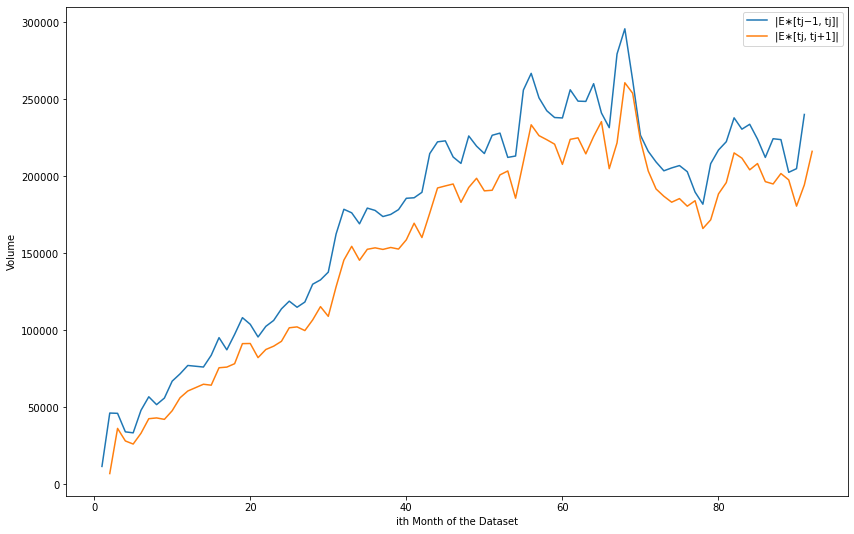

In [18]:
# Graphical representation of volumes as functions of coupled time periods (Tj, Tj+1)
plt.figure(figsize=(14,9))
plt.plot([i for i in range(1,len(time_periods))], E_STAR_PREV, label='|E∗[tj−1, tj]|')
plt.plot([i for i in range(2,len(time_periods)+1)], E_STAR_NEXT, label='|E∗[tj, tj+1]|')
plt.xlabel('ith Month of the Dataset')
plt.ylabel('Volume')
plt.legend()
plt.show()

The plot shows that when 2 nodes are in the network for 2 consecutive time periods, they are more likely to have connected in the first period rather than the second. The number of edges between such nodes appears to be consistently higher in the 1st period compared to the 2nd. We will also create a plot to visualize the difference between these two scenarios.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


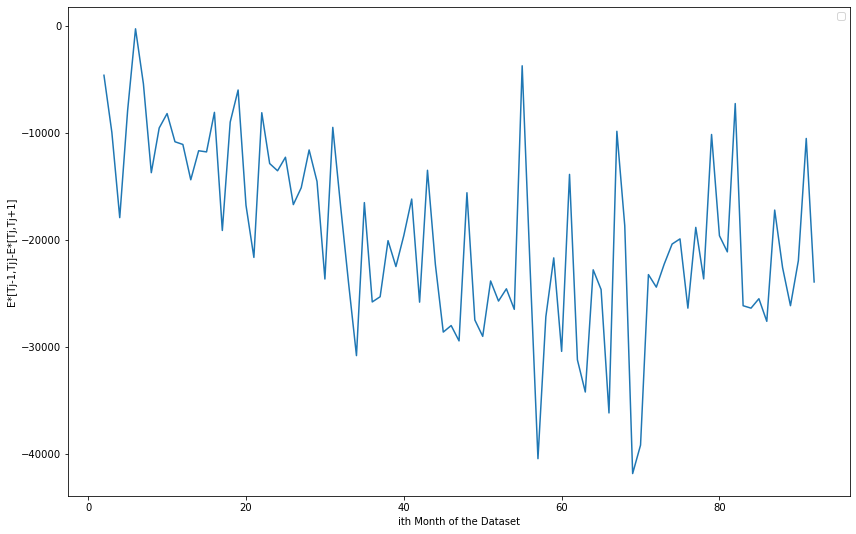

In [19]:
# Calculate The Difference between the successive time periods
E_STAR_DIFF = (np.array(E_STAR_NEXT) - np.array(E_STAR_PREV))

# Create the plot of Diff
plt.figure(figsize=(14,9))
plt.plot([i for i in range(2,len(time_periods)+1)], E_STAR_DIFF)
plt.xlabel('ith Month of the Dataset')
plt.ylabel('E*[Tj-1,Tj]-E*[Tj,Tj+1]')
plt.legend()
plt.show()

Once more, it's evident that the difference between the number of edges on the first and second days is consistently negative. These plots also suggest that as time progresses, the difference between them tends to increase. Let's also examine how common nodes evolve over time.

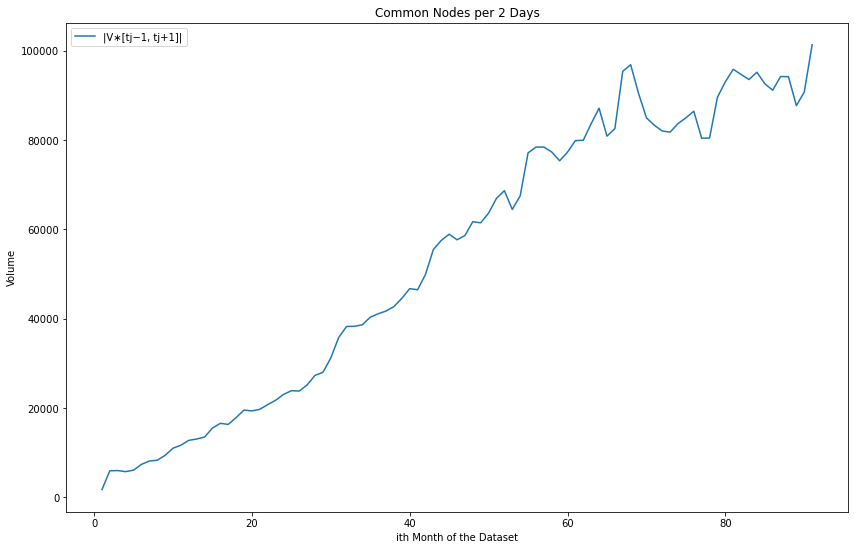

In [20]:
plt.figure(figsize=(14,9))
plt.plot(range(1, N), V_STAR, label='|V∗[tj−1, tj+1]|')
plt.xlabel('ith Month of the Dataset')
plt.ylabel('Volume')
plt.title('Common Nodes per 2 Days')
plt.legend()
plt.show()

# Similarity Metrics

**a) SGD (Graph Distance):<br>SGD(u, v) represents the similarity between nodes u and v based on their graph distance. The graph distance between two nodes is the length of the shortest path between them in the graph.To calculate the similarity, we take the negative value of the graph distance. So, the relationship is:<br><center>SGD(u, v) = - dgeodesic(u, v)</center>**<br>

**b) SCN (Common Neighbors):<br>SCN(u, v) calculates the similarity between nodes u and v based on the number of common neighbors they have.To compute the similarity, we count the number of common neighbors and square the result. The relationship is:<br><center>SCN(u, v) = |Γ(u) ∩ Γ(v)|</center><br>Here, Γ(u) represents the set of neighbors of node u, and Γ(v) represents the set of neighbors of node v. The more common neighbors two nodes have, the higher their similarity will be.**<br><br>

**c) SJC (Jaccard’s Coefficient):<br>SJC(u, v) calculates the Jaccard coefficient, a similarity measure based on the size of the intersection of their neighbor sets and the size of their union. The relationship is:<br><center>SJC(u, v) = |Γ(u) ∩ Γ(v)| / |Γ(u) ∪ Γ(v)|</center><br>The Jaccard coefficient ranges from 0 to 1, where 0 means no common neighbors, and 1 means both nodes have exactly the same neighbors. Higher values indicate higher similarity.**<br><br>

**d) SA (Adamic / Adar):<br>SA(u, v) calculates the Adamic/Adar similarity between nodes u and v. It is similar to the Common Neighbors metric (SCN), but it assigns different weights to the common neighbors based on their degree (number of neighbors). The relationship is:<br><center>SA(u, v) = Σ (1 / log(|Γ(z)|))</center><br>Here, the higher the SA value, the more similar the nodes are based on the degrees (number of neighbors) of their common neighbors.**<br><br>

**e) SPA (Preferential Attachment):<br>SPA(u, v) measures the similarity between nodes u and v based on the product of their degrees (number of neighbors). The relationship is:<br><center>SPA(u, v) = |Γ(u)| * |Γ(v)|</center><br>SPA suggests that nodes with a high number of neighbors tend to connect with other nodes that also have many neighbors. So, the more neighbors two nodes have, the higher their similarity will be.**

In [21]:
# First we need to check if the V* have empty ensemble
V_STAR[0]

1713

In [22]:
# Calculate the graph distance (SGD) between two nodes u and v in a subgraph
def graph_distance(subgraph, u, v):
    shortest_path = nx.shortest_path_length(subgraph, source=u, target=v)
    if shortest_path == 0:
        return 0 # If there is no path, return 0 to represent maximum distance (disconnected nodes)
    return 1 / shortest_path

# Calculate the common neighbors (SCN) between two nodes u and v in a subgraph
def common_neighbors(subgraph, u, v):
    neighbors_u = set(subgraph[u])
    neighbors_v = set(subgraph[v])
    return len(neighbors_u.intersection(neighbors_v))

# Calculate Jaccard's coefficient (SJC) between two nodes u and v in a subgraph
def jaccard_coefficient(subgraph, u, v):
    neighbors_u = set(subgraph[u])
    neighbors_v = set(subgraph[v])
    union_size = len(neighbors_u.union(neighbors_v))
    if union_size == 0:
        return 0
    return len(neighbors_u.intersection(neighbors_v)) / union_size

# Calculate Adamic/Adar (SA) score between two nodes u and v in a subgraph
def adamic_adar(subgraph, u, v):
    common_neighbors = set(subgraph[u]).intersection(set(subgraph[v]))
    if len(common_neighbors) == 0:
        return 0
    return sum(1 / log(len(subgraph[neighbor]), 2) if log(len(subgraph[neighbor]), 2) != 0 else 0 for neighbor in common_neighbors)

# Calculate Preferential Attachment (SPA) between two nodes u and v in a subgraph
def preferential_attachment(subgraph, u, v):
    degree_u = subgraph.degree(u)
    degree_v = subgraph.degree(v)
    return degree_u * degree_v

In [23]:
# Create a list to store the dictionaries
similarity_data = []

# Loop through each pair of successive time periods (Tj, Tj+1) where 1 ≤ j ≤ N - 1
for j in range(N - 1):
    # Get the subgraphs for the current and next time periods
    subgraph_j = ith_subgraph(df, time_periods, j)
    subgraph_j_next = ith_subgraph(df, time_periods, j+1)

    # Compute the common set of nodes V∗[tj−1, tj+1]
    v_star = common_nodes(subgraph_j, subgraph_j_next)

    # Iterate through each pair of nodes (u, v) in the original subgraph
    for u, v in subgraph_j.edges():
        # Check if both nodes u and v are in the common set v_star
        if u in v_star and v in v_star:
            # Compute the similarity measures for the current pair (u, v)
            sgd = graph_distance(subgraph_j, u, v)
            scn = common_neighbors(subgraph_j, u, v)
            sjc = jaccard_coefficient(subgraph_j, u, v)
            sa = adamic_adar(subgraph_j, u, v)
            spa = preferential_attachment(subgraph_j, u, v)
            
            # Append the similarity measures to the list
            similarity_data.append({
                'from': u,
                'to': v,
                'SGD': sgd,
                'SCN': scn,
                'SJC': sjc,
                'SA': sa,
                'SPA': spa
            })
            
    print(j)

# Create the DataFrame outside the loop
similarity_df = pd.DataFrame(similarity_data)
similarity_df.head(15)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


,from,to,SGD,SCN,SJC,SA,SPA
0,8,9,1.0,1,0.035714,0.143559,120
1,8,55,1.0,0,0.000000,0.000000,160
2,8,39,1.0,0,0.000000,0.000000,130
3,8,446,1.0,0,0.000000,0.000000,60
4,8,905,1.0,1,0.007752,0.218104,625
5,9,72,1.0,2,0.024390,0.337907,1440
6,9,115,1.0,1,0.012048,0.169294,1440
7,9,227,1.0,0,0.000000,0.000000,1080
8,9,234,1.0,0,0.000000,0.000000,2760
9,9,46,1.0,3,0.049180,0.482459,960


In [24]:
similarity_df.tail()

,from,to,SGD,SCN,SJC,SA,SPA
15799832,670521,801807,1.0,1,0.333333,0.127259,4
15799833,3775937,2852913,1.0,0,0.000000,0.000000,2
15799834,492901,2599892,1.0,0,0.000000,0.000000,1
15799835,2414247,3606887,1.0,0,0.000000,0.000000,1
15799836,879917,5046642,1.0,0,0.000000,0.000000,2


In [25]:
# As we observe we have duplicates
similarity_df[similarity_df['from'] == 9]

,from,to,SGD,SCN,SJC,SA,SPA
5,9,72,1.0,2,0.024390,0.337907,1440
6,9,115,1.0,1,0.012048,0.169294,1440
7,9,227,1.0,0,0.000000,0.000000,1080
8,9,234,1.0,0,0.000000,0.000000,2760
9,9,46,1.0,3,0.049180,0.482459,960
10,9,22,1.0,2,0.054054,0.309606,360
11,9,404,1.0,2,0.027397,0.331461,1224
12,9,26,1.0,2,0.022989,0.424571,1560
13,9,1693,1.0,1,0.010638,0.187902,1704
14,9,905,1.0,5,0.034722,1.219441,3000


In [26]:
# We drop duplicates
df = similarity_df.drop_duplicates(subset=['from', 'to'],keep = 'first')

# Also we drop the edges which connect the same node
df = df[df['from'] != df['to']]

In [27]:
df.tail(10)

,from,to,SGD,SCN,SJC,SA,SPA
15799827,1141389,3623398,1.0,0,0.000000,0.000000,1
15799828,4405887,5882260,1.0,0,0.000000,0.000000,1
15799829,2202489,2533632,1.0,0,0.000000,0.000000,1
15799830,26300,5376372,1.0,0,0.000000,0.000000,1
15799831,5885926,1680249,1.0,0,0.000000,0.000000,4
15799832,670521,801807,1.0,1,0.333333,0.127259,4
15799833,3775937,2852913,1.0,0,0.000000,0.000000,2
15799834,492901,2599892,1.0,0,0.000000,0.000000,1
15799835,2414247,3606887,1.0,0,0.000000,0.000000,1
15799836,879917,5046642,1.0,0,0.000000,0.000000,2


In [28]:
descr = df.describe().astype(str)
descr

,from,to,SGD,SCN,SJC,SA,SPA
count,14728908.0,14728908.0,14728908.0,14728908.0,14728908.0,14728908.0,14728908.0
mean,1065243.4896154555,1331292.6945435465,1.0,0.9626595535799395,0.00733382571399452,0.17995814633650117,3132.621754918966
std,1170455.3130619894,1332964.760641265,0.0,2.5109486335232507,0.01613420323701981,0.5026060810820164,10917.84949697371
min,1.0,1.0,1.0,0.0,0.0,0.0,1.0
25%,192001.0,288579.0,1.0,0.0,0.0,0.0,132.0
50%,637853.0,893130.0,1.0,0.0,0.0,0.0,568.0
75%,1506700.0,1946636.0,1.0,1.0,0.009009009009009009,0.1762914343888821,2170.0
max,5982313.0,5982313.0,1.0,135.0,0.6666666666666666,43.65443411008444,1450445.0


Here, we demonstrate how to compute similarity metrics. In the subsequent Jupyter notebooks, we will apply these formulas to prepare the data for solving a link prediction problem with three different approaches.